# Analyzing Amazon Inventory Stock in Image Bins Using AWS Sagemaker.
This notebook contains code for training a pytorch model on Amazon Inventory dataset. The dataset contains images of bin ofs items that are sold by amazon on their ecommerce business

The script starts by installing and loading the  packages necessary to complete our project. Our project majorly uses `pytorch, torch` and `torchvision`  packages to train and test a deep learning model.
We download data from the amazon imagery website.

After data download we upload the data to a specified AWS S3 bucket. We then create an estimator that will fetch data from this bucket ,given necessary authentication and fit on the data using an already prepared `train.py` script. 

We observe  the output of this model fitting to judge the performance of  our model. All this accomplished on AWS Cloud platform using `sagemaker`.

In [77]:
%%capture
#  Install any packages that you might need
!pip install --no-cache-dir smdebug torch pytorch torchvision tqdm split-folders

In [78]:
#  Import any packages that you might need
import splitfolders
from tqdm import tqdm

import sagemaker

from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [79]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

# download_and_arrange_data()

## Dataset

Our project uses [Amazom Image Bin Data Set](https://registry.opendata.aws/amazon-bin-imagery/). The dataset contains images of inventory of bins for items that are traded in Amazon e-commerce platform. 

The official description of the data by the website is as follows;

  *The Amazon Bin Image Dataset contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations.*
  
  However in our project we will just use some of the data, just about 10,000 images. 
  
  The dataset images are grouped into `folders` with names denoted by numbers 1 up to 5. With the numbers representing the number of items contained in each  of the images respectively.So the `folder` name 1 holds bins images with 1 item, the same goes for folder 2 and so on. 
  
  The downloded `train_data` is split into `train`, `test` and `val` ,each containing data for training, testing and validation respectively [splitfolders package](https://pypi.org/project/split-folders/).
  
You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

## Data Exploration.

Let display some of the image data to observe what is contained in it.Looking at the image with our bare eyes, we see it to hod two items.We will aim to train our model also to be able to detect such. 

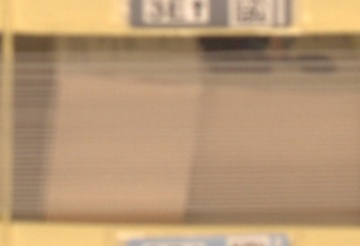

In [120]:
from PIL import Image
image_name = './train_data/2/00034.jpg'
display(Image.open(image_name))

In [80]:
# Perform any data cleaning or data preprocessing
from sklearn.model_selection import train_test_split

#splitfolders.ratio('train_data', output="train_data", seed=1337, ratio=(.6, 0.2,0.2)) 

In [81]:


%%capture 
!aws s3 sync train_data s3://amzn-buckett/


## Model Training

For model traing we us `resnet34` model that was proposed to perform best by our benchmark model.The model configuration are specified in the `train.py` script. 

The architecture is initialiazed as follows; 

```
net = models.__dict__[args.arch]()
        
in_features = net.fc.in_features
new_fc = nn.Linear(in_features,6)
net.fc = new_fc
model=net

```
The model names is specified in `args.arch` arguments with `resnet34` set to be the default.See below;

```parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet34', choices=model_names, help='model architecture: ' + ' | '.join(model_names) + ' (default: resnet34)')```

You can specify the model you want by `model` variable to set your preffered model. The variable stores the names in a dictionary.


**Note:** You will need to use the `train.py` script to train your model.

**Note:** You will need to use the `train.py` script to train your model.

In [82]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([128, 256, 512]),
}

role = sagemaker.get_execution_role()



In [83]:
# Create your training estimator
estimator = PyTorch(
    entry_point="train.py",
    base_job_name='job-amazon-bins',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)


In [84]:
os.environ['SM_CHANNEL_TRAINING']='s3://amzn-buckett/'
os.environ['SM_MODEL_DIR']='s3://amzn-buckett/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://amzn-bukett/output/'

In [85]:
estimator.fit({"training": "s3://amzn-buckett/"}, wait=True)

2022-01-17 19:28:02 Starting - Starting the training job...
2022-01-17 19:28:25 Starting - Launching requested ML instancesProfilerReport-1642447681: InProgress
......
2022-01-17 19:29:26 Starting - Preparing the instances for training.........
2022-01-17 19:30:46 Downloading - Downloading input data..................
2022-01-17 19:34:04 Training - Downloading the training image...
2022-01-17 19:34:27 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-17 19:34:23,281 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-17 19:34:23,304 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-17 19:34:26,320 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-17 19:34:34,206 sagemaker-containers INFO     Module default_user_module_name does no

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [86]:

# Declare your HP ranges, metrics etc.
#hyperparameter_ranges = {
   # "learning_rate": ContinuousParameter(0.001, 0.1),
  #  "batch_size": CategoricalParameter([ 128, 256]),


#role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [89]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="train.py",
    base_job_name = 'amazon-hpo-job',
    role=role,
    py_version='py3',
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.c5.xlarge"
    )

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=4,
    objective_type=objective_type,
)

In [90]:
# TODO: Fit your estimator
tuner.fit({"training": "s3://amzn-buckett/"}, wait=True)

.........................................................................................................................................................................................................................................................................................................!


In [92]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-17 20:41:43 Starting - Preparing the instances for training
2022-01-17 20:41:43 Downloading - Downloading input data
2022-01-17 20:41:43 Training - Training image download completed. Training in progress.
2022-01-17 20:41:43 Uploading - Uploading generated training model
2022-01-17 20:41:43 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.005528833679560765',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"amazon-hpo-job-2022-01-17-20-19-24-185"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-953953830980/amazon-hpo-job-2022-01-17-20-19-24-185/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [93]:
#  Set up debugging and profiling rules and hooks

from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

loss_not_decreasing_rule = Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                         rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                         "mode": "TRAIN"})

rules = [
    loss_not_decreasing_rule,
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [94]:
#  Create and fit an estimator
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}

#yperparameters = {"batch_size": "32", "lr": "0.0033394403406322728"}
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    entry_point="train_model.py",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config,
    rules=rules
)
estimator.fit({"training": "s3://amzn-buckett"}, wait=True)

2022-01-17 20:49:20 Starting - Starting the training job...
2022-01-17 20:49:23 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-17 20:50:34 Starting - Preparing the instances for training.........
2022-01-17 20:52:15 Downloading - Downloading input data..................
2022-01-17 20:55:17 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-17 20:55:13,221 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-17 20:55:13,223 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-17 20:55:13,232 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-17 20:5

In [95]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
#print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))


Training jobname: pytorch-training-2022-01-17-20-49-19-078
[2022-01-17 21:05:56.102 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:5617 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-953953830980/pytorch-training-2022-01-17-20-49-19-078/debug-output
[2022-01-17 21:05:56.504 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:5617 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 13543 more expected)', IncompleteRead(0 bytes read, 13543 more expected)) while reading s3://sagemaker-us-east-1-953953830980/pytorch-training-2022-01-17-20-49-19-078/debug-output/index/000000000/000000000000_worker_0.json . Will retry now
[2022-01-17 21:05:58.513 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:5617 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-17 21:05:59.537 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:5617 INFO trial.py:210] Loa

In [96]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [97]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.savefig('loss-graph.png')
 
    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


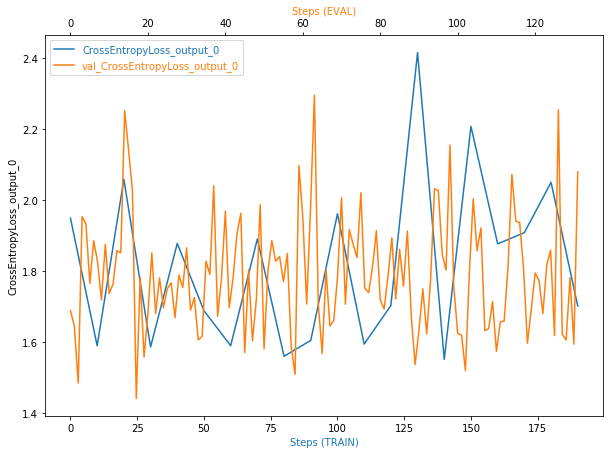

In [98]:
# plot debugging output
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [99]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-953953830980/pytorch-training-2022-01-17-20-49-19-078/rule-output


In [100]:
! aws s3 ls {rule_output_path} --recursive

2022-01-17 21:05:34     377201 pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-17 21:05:33     225157 pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-17 21:05:28        192 pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-17 21:05:28        200 pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-17 21:05:28       2285 pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-17 21:05:28        127 pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-17 21:05:28        199 pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-re

In [101]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2022-01-17-20-49-19-078/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2022-01-17-20-49-

In [102]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [103]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [104]:
# TODO: Deploy your model to an endpoint
model_location=estimator.model_data

import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [105]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [106]:
# TODO: Run an prediction on the endpoint

In [107]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [108]:
# TODO: Cost Analysis

In [109]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [110]:
# TODO: Train your model on Multiple Instances